In [38]:
import pandas as pd
import riskfolio as rp
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import warnings
warnings.filterwarnings('ignore')

from fredapi import Fred
key='##'

fred = Fred(api_key=key)

# Regime based asset allocation

1. Define the economics regimes:
    * Obtain historical inflation YoY change and recession dummy indicator
    * Define 4 regimes
2. Prediction with Random Forest and Genetic Algorithm:
    * Inflation 12 months ahead YoY inflation and Recession nowcasting (for out-of sample regime classification)
    * One-month ahead asset returns
3. Bayesian inference to combine predictions and past returns
4. Mean-CDaR Portfolio Optimization
5. Backtest



## Regimes

In [2]:
data={}
codes={'Inflation': 'CPIAUCSL','Recession':'USRECD','Infl Expectations': 'EXPINF1YR'}

for i in codes.values():
    data[i]=fred.get_series(i)

In [3]:
df=pd.DataFrame.from_dict(data).dropna()
df.columns=codes.keys()
df['Inflation']=df['Inflation'].pct_change(12)*100
df.dropna(inplace=True)
df['Infl Expectations']=df['Infl Expectations'].shift(12)

In [4]:
predicted=pd.read_csv('predicted.csv',parse_dates=True,index_col=0)
predicted.columns=['Predicted']
df=df.join(predicted)

In [5]:
df=df.join(pd.read_csv('recession.csv',parse_dates=True,index_col=0)['Nowcasting'])

In [6]:
split='2007-05-01'
df_test=df.loc[split:]
df_train=df.loc[:split]

In [7]:
df_train['Inflation Binary']=pd.get_dummies(df_train['Infl Expectations'].rolling(12).mean()<df_train['Inflation'].rolling(12).mean(),drop_first=True)
df_train['Recession Binary']=df_train['Recession']

df_test['Inflation Binary']=pd.get_dummies(df_test['Infl Expectations'].rolling(12).mean()+2<df_test['Predicted'].rolling(4).mean(),drop_first=True)
df_test['Recession Binary']=pd.get_dummies(df_test['Nowcasting']>0.5,drop_first=True)


<AxesSubplot:>

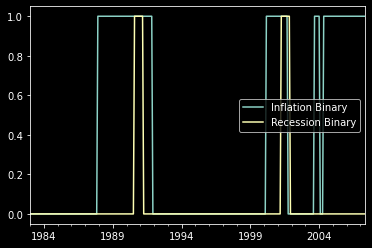

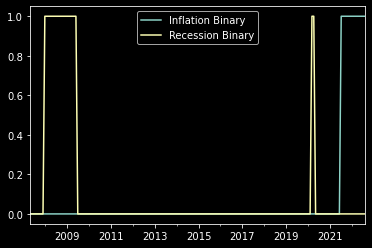

In [8]:
df_train[['Inflation Binary','Recession Binary']].plot()
df_test[['Inflation Binary','Recession Binary']].plot()

In [9]:
df_=pd.concat([df_train[['Inflation Binary','Recession Binary']],df_test[['Inflation Binary','Recession Binary']].iloc[1:]])

In [10]:
regimi=pd.DataFrame(['Recessione', 'Stagflazione', 'Crescita', 'Crescita inflazionistica'],columns=['Regimi'])
regimi

,Regimi
0,Recessione
1,Stagflazione
2,Crescita
3,Crescita inflazionistica


In [11]:
regimes=np.zeros(len(df_))
regimes[np.logical_and(df_['Inflation Binary']==1,df_['Recession Binary']==1)]=1
regimes[np.logical_and(df_['Inflation Binary']==0,df_['Recession Binary']==0)]=2
regimes[np.logical_and(df_['Inflation Binary']==1,df_['Recession Binary']==0)]=3

<AxesSubplot:>

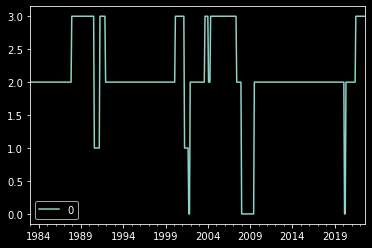

In [12]:
pd.DataFrame(regimes,index=df_.index).plot()

## Bond TR index

In [13]:
import yfinance
assets={'Gold': '^XAU','10 years':'^TNX','5 years': '^FVX','S&P500':'^GSPC','Commodities':'^SPGSCI','Cash':'^IRX'}
assets=dict(sorted(assets.items(), key=lambda item: item[1]))
data_=yfinance.download(list(assets.values()))['Adj Close'].dropna()

[*********************100%***********************]  6 of 6 completed


Following Swinkels (2019):

Given the yield-to-maturity and remaining maturity, the interest rate sensitivity or modified duration of a risk-free bond at par value can be approximated by
$$
D_{\mathfrak{t}}\left(Y_t, M_t\right)=1 / Y_t \cdot\left[1-1 /\left(1+0.5 \cdot Y_t\right)^{2 \cdot M}{ }_t\right],
$$
with $Y_t$ the yield-to-maturity at time $t$ and $M_t$ the remaining maturity of the bond at time $t$. The convexity $C_t$ of a par bond, which measures the non-linear relationship between the price and yield of a bond can be approximated with
$$
\left.C_t\left(Y_t, M_t\right)=2 /\left(Y_{\mathrm{t}}^2\right) \cdot\left[1-1 /\left(1+0.5 \cdot Y_{\mathrm{t}}\right)^{2 \cdot M t}\right)\right]-\left(2 \cdot M_t\right) /\left[Y_t \cdot\left(1+0.5 \cdot Y_t\right)\right]^{2 \cdot M_t+1} .
$$
For better approximations, the dispersion in maturity of the bond portfolio is needed as an input, which we do not have available. Now, we can calculate the investment return over period $t$ when we know the yield at the beginning and the end of the period, and the maturity of the bond
$$
R_t\left(Y_{\mathrm{t}-1}, Y_t, M_t\right)=Y_{\mathrm{t}-1}-D_t \cdot\left(Y_t-Y_{t-1}\right)+\frac{1}{2} \cdot C_{\mathrm{t}} \cdot\left(Y_{\mathrm{t}}-Y_{t-1}\right)^2
$$

<AxesSubplot:xlabel='Date'>

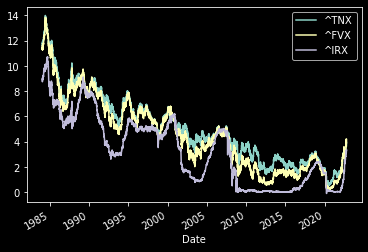

In [14]:
data_[['^TNX','^FVX','^IRX']].plot()

In [15]:
def bond_tr(y,m,k=(1/252)):
    z=1+y*0.5
    duration=(1-1/(z**(2*m)))/y
    convexity=(2/(y**2))*(1-1/(z**(2*m)))-(2*m)/(y*(z)**(2*m))
    b_rets=(1+y)**(1/252)-1-duration*(y-y.shift(1))+0.5*convexity*((y-y.shift(1))**2)
    return (1+b_rets).cumprod()

In [16]:
data_['^TNX']=bond_tr(data_['^TNX']/100,10)
data_['^FVX']=bond_tr(data_['^FVX']/100,5)
data_['^IRX']=bond_tr(data_['^IRX']/100,1,k=(91/252))


<AxesSubplot:xlabel='Date'>

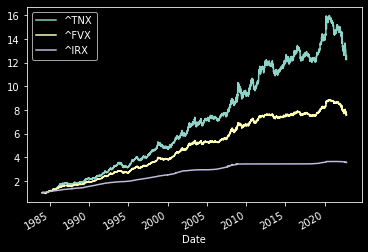

In [17]:
data_[['^TNX','^FVX','^IRX']].plot()

## Returns analysis

In [18]:
returns=data_.resample('W').ffill().join(pd.DataFrame(regimes,index=df_.index).resample('W').ffill())
returns.iloc[:,:6]=returns.iloc[:,:6].pct_change()
returns.columns=list(assets.keys())+['Regime']
returns.dropna(inplace=True)
display(returns)

,5 years,S&P500,Cash,Commodities,10 years,Gold,Regime
Date,,,,,,,
1984-01-15,0.008560,-0.013351,0.002911,0.004197,0.010447,-0.009185,2.0
1984-01-22,-0.000121,-0.004850,-0.000467,-0.003240,-0.000724,0.016760,2.0
1984-01-29,0.002503,-0.013657,0.002261,0.012908,0.002769,0.012708,2.0
1984-02-05,0.002130,-0.018482,0.001226,-0.017208,0.003944,0.068200,2.0
1984-02-12,-0.005661,-0.028650,0.000785,-0.037715,-0.011040,-0.046991,2.0
...,...,...,...,...,...,...,...
2022-07-10,-0.011335,0.019358,-0.002085,-0.030542,-0.017503,-0.044961,3.0
2022-07-17,0.004797,-0.009289,-0.003475,-0.056214,0.015406,-0.052583,3.0
2022-07-24,0.008882,0.025489,-0.000667,0.007563,0.013456,-0.001744,3.0


<AxesSubplot:xlabel='Date'>

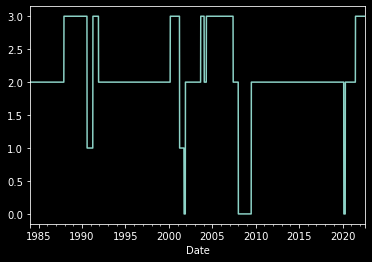

In [19]:
returns['Regime'].plot()

In [20]:
returns_train=returns[returns.index < split]
returns_test=returns[returns.index > split]

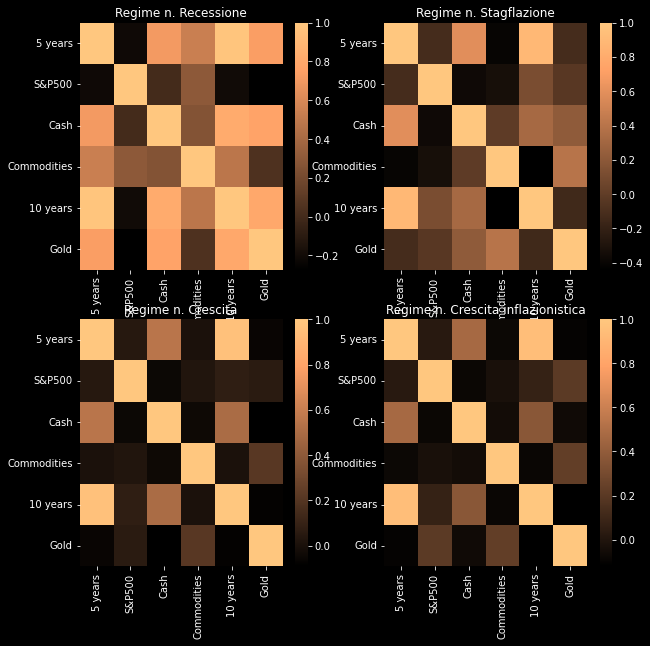

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
for i in range(0,4):
    ax = fig.add_subplot(2,2,i+1)
    sns.heatmap(returns_train[returns_train['Regime']==i].drop('Regime',axis=1).corr(),cmap='copper',ax=ax)
    plt.title('Regime n. '+str(regimi.iloc[i].values[0]))

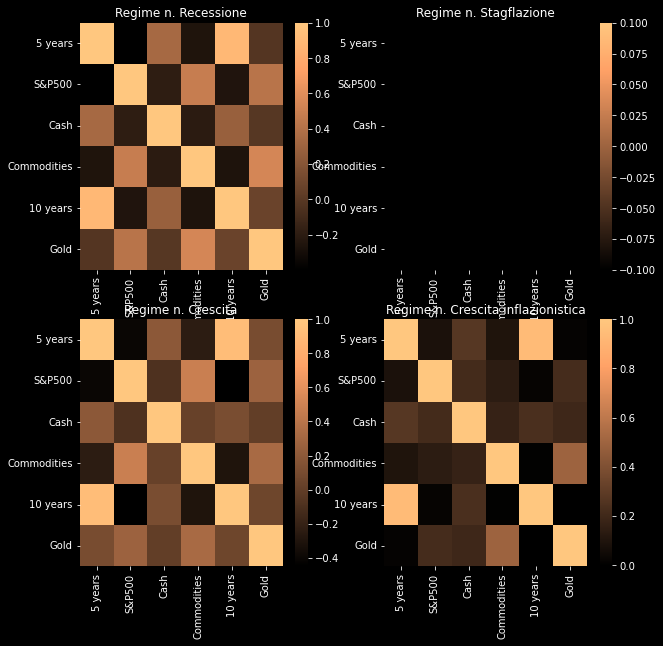

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
for i in range(0,4):
    ax = fig.add_subplot(2,2,i+1)
    sns.heatmap(returns_test[returns_test['Regime']==i].drop('Regime',axis=1).corr(),cmap='copper',ax=ax)
    plt.title('Regime n. '+str(regimi.iloc[i].values[0]))

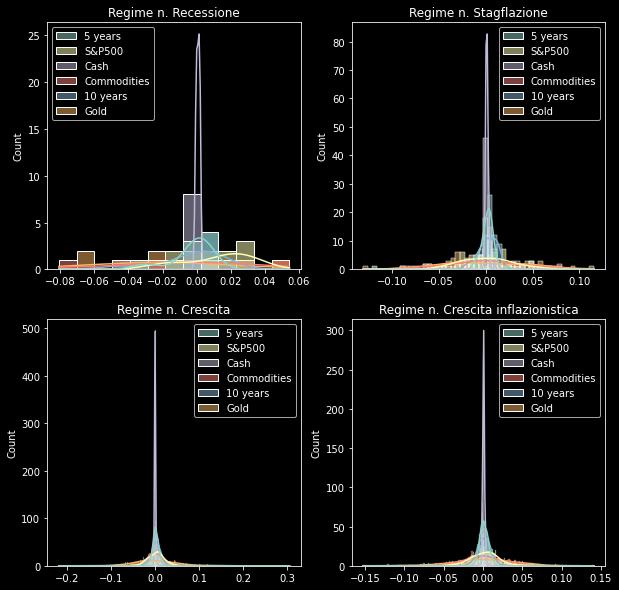

In [23]:
fig = plt.figure(figsize=(10, 10))
for i in range(0,4):
    ax = fig.add_subplot(2,2,i+1)
    sns.histplot(returns_train[returns_train['Regime']==i].drop(['Regime'],axis=1),kde='True',ax=ax)
    plt.title('Regime n. '+str(regimi.iloc[i].values[0]))

# Bayesian inference


In [24]:
xgb=(pd.read_csv('predictions.csv',index_col=0,parse_dates=True).resample('W').ffill()/100+1)**(1/(4*5))-1
returns=returns.join(xgb).dropna()
returns.head()

,5 years,S&P500,Cash,Commodities,10 years,Gold,Regime,^FVX,^GSPC,^IRX,^SPGSCI,^TNX,^XAU
Date,,,,,,,,,,,,,
1992-10-04,0.005829,-0.009364,0.002195,0.006955,0.012322,-0.017160,2.0,0.000023,-0.000001,0.000005,-0.000010,0.000027,-2.590055e-07
1992-10-11,-0.011010,-0.019027,-0.001417,0.009936,-0.017515,0.000628,2.0,0.000023,-0.000001,0.000005,-0.000010,0.000027,-2.590055e-07
1992-10-18,-0.002163,0.022525,-0.000231,-0.002420,-0.004770,-0.036154,2.0,0.000023,-0.000001,0.000005,-0.000010,0.000027,-2.590055e-07
1992-10-25,-0.013339,0.005756,0.000284,-0.025103,-0.015028,0.001693,2.0,0.000023,-0.000001,0.000005,-0.000010,0.000027,-2.590055e-07
1992-11-01,0.001570,0.011060,0.000282,-0.013253,0.003484,-0.016903,2.0,0.000021,0.000004,0.000005,-0.000011,0.000026,-1.156321e-07



<img src="https://cdn.mathpix.com/snip/images/w_LetlLD4eZ4u7qN00nUeB9w7k85watXrLh1hcjgFEY.original.fullsize.png">

* Priors: Random Forest forecasts
* Likehood: Sample mean in the same regime
* Posterior: Input for portfolio optimization

$$
f_{p r}(\mu) \sim N\left(\mu_0, \Psi_0\right)
$$
$$
\begin{aligned}
\mu_1 &=\left[\Psi_0^{-1}+T \Sigma^{-1}\right]^{-1}\left(\Psi_0^{-1} \mu_0+T \Sigma^{-1} \widehat{\mu}\right) \\
\Sigma_1 &=\left[\Psi_0^{-1}+T \Sigma^{-1}\right]^{-1}
\end{aligned}
$$
$$
f\left(R_{t+1} \mid \mu, \Sigma\right) \sim N\left(\mu_1, \Sigma+\Sigma_1\right)
$$

In [25]:
def posterior(returns,i):
    from scipy.stats import gmean
    rets=returns.iloc[:i][returns['Regime'].iloc[:i]==returns.iloc[i]['Regime']].drop('Regime',axis=1)
    likehood=np.array(rets.iloc[:,:6])
    prior=np.array(rets.iloc[:,6:])
    mu_0=(prior[-1])

    cov_0=pd.DataFrame((np.roll(likehood,-4)-prior)).cov()

    mu_l=gmean(likehood+1)-1
    sigma_l=pd.DataFrame(likehood).cov()
    n=rets.shape[0]

    mu1=np.linalg.inv(np.linalg.inv(cov_0)+n*np.linalg.inv(sigma_l))@(np.linalg.inv(cov_0)@mu_0+n*np.linalg.inv(sigma_l)@mu_l)
    sigma1=np.linalg.inv(np.linalg.inv(cov_0)+n*np.linalg.inv(sigma_l))
    sigma_pred=sigma1+sigma_l

    return mu1, sigma_l


In [26]:
postmu,postvar,dates=[],[],[]
start=returns.reset_index()[returns.index>=returns_test.index[0]].index[0]
for i in range(start,len(returns)):
    if returns.iloc[i].name.month!=returns.iloc[i-1].name.month:
        mu,var=posterior(returns,i)
        postmu.append(mu)
        postvar.append(var)
        dates.append(returns.iloc[i].name)

## Last predictions

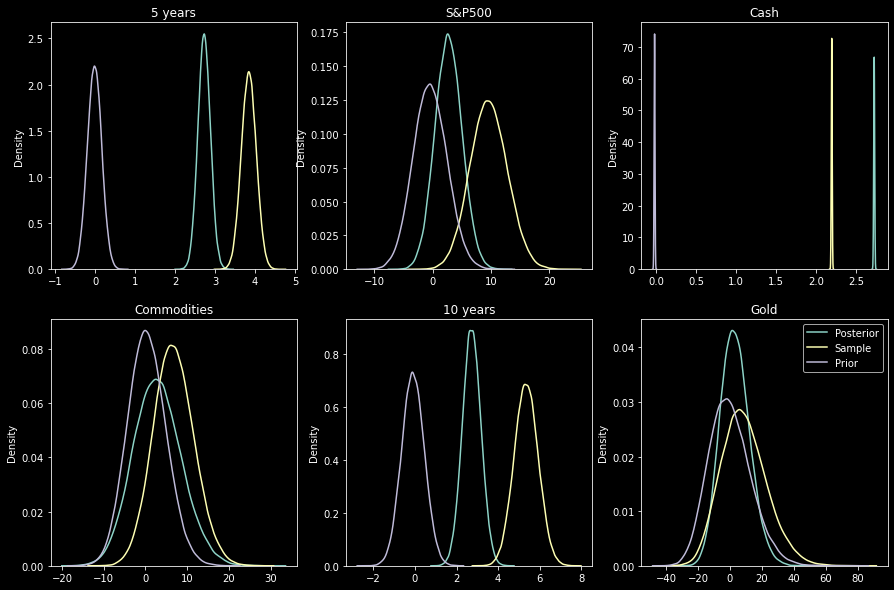

In [27]:
fig = plt.figure(figsize=(15, 10))

for i in range(0,6):
    ax = fig.add_subplot(2,3,i+1)
    x = (np.random.normal(postmu[-1][0],postvar[-1][i][i],size=100000)+1)**(52)-1
    y = (np.random.normal(np.array(returns.iloc[:,i].mean()),returns.iloc[:,i].var(),size=100000)+1)**(52)-1
    z=(np.random.normal(np.array(returns.iloc[-1,i+7]),pd.DataFrame((np.roll(returns.iloc[:,i],-4)-returns.iloc[:,i+7])).var()[0],size=100000)+1)**(52)-1
    sns.kdeplot(x*100,label='Posterior',ax=ax)
    sns.kdeplot(y*100,label='Sample',ax=ax)
    sns.kdeplot(z*100,label='Prior',ax=ax)
    plt.title(list(assets.keys())[i])
plt.legend()
plt.show()

# Portfolio Optimization

$$
\operatorname{CDaR}_\alpha(X)=\operatorname{DaR}_\alpha(X)+\frac{1}{\alpha T} \sum_{j=0}^T \max \left[\max _{t \in(0, j)}\left(\sum_{i=0}^t X_i\right)-\sum_{i=0}^j X_i-\operatorname{DaR}_\alpha(X), 0\right]
$$

$$
\begin{array}{ll}
\max _w & R(w)-\lambda \operatorname{CDaR}_\alpha(w) \\
\text { s.t. } & A w \geq B \\
\end{array}
$$

In [28]:
asset_classes = {'Assets': assets.keys(), 
                 'Type': ['Bond','Stock','Cash','Commodities','10 Year','Gold']}
asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])
constraints = {'Disabled': [False,],'Type': ['Classes'],'Set': ['Type'],'Position': ['Cash'],'Sign': ['<='], 'Weight': [0],'Type Relative': [''],'Relative Set': [''],'Relative': [''],'Factor': ['']}
constraints = pd.DataFrame(constraints)
A, B = rp.assets_constraints(constraints, asset_classes)



In [29]:
import riskfolio as rp
w=[]
c=0
for i in tqdm(range(start, len(returns))):
    if returns.iloc[i].name.month!=returns.iloc[i-1].name.month:
        port=rp.Portfolio(returns[returns['Regime']==returns['Regime'].iloc[i]].iloc[:i,:6])
        port.mu=pd.DataFrame(postmu[c]).T
        port.cov=pd.DataFrame(postvar[c])
        port.ainequality = A
        port.binequality = B
        w.append(port.optimization(obj='Utility',rm='CDaR'))
        c+=1

100%|██████████| 797/797 [00:16<00:00, 47.91it/s] 


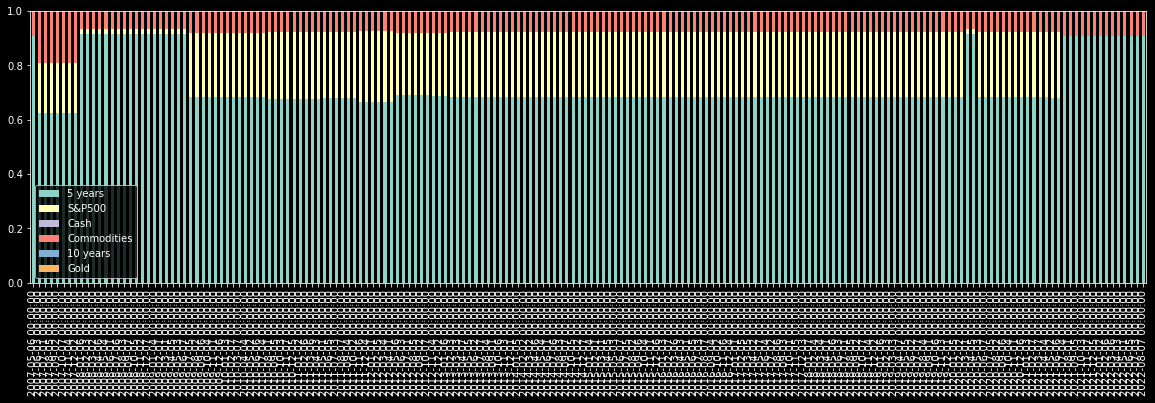

In [30]:
weights=pd.DataFrame(np.concatenate(w,axis=1),index=returns.columns[:6],columns=dates).T
weights.plot.bar(stacked=True,figsize=(20,5))
plt.show()

# Backtest

In [31]:
def drawdown(x):
    return (x-x.expanding().max())/x

def stats(hist,m=52):
    so=sortino(hist)
    std=hist.pct_change().std()[0]*(m**0.5)
    cagr=(((hist.iloc[-1]/hist.iloc[0])**(m/len(hist))-1)).values[0]
    sh=cagr/std
    dd=((hist-hist.expanding().max())/hist.expanding().max()).mean()[0]
    return cagr,std,sh,dd,so
    
def sortino(df,m=52):
    df=df.iloc[:,0]
    expected_return = (df[-1]/df[0])**(m/len(df))-1
    df=df.pct_change().dropna()
    # Create a downside return series with the negative returns only
    downside_returns = df.loc[df < 0]

    # Calculate expected return and std dev of downside
    
    down_stdev = downside_returns.std()*(m**0.5)

    # Calculate the sortino ratio
    sortino_ratio = (expected_return)/down_stdev
    return sortino_ratio

In [32]:
weights_w=weights.resample('W').ffill()

In [33]:
ptfr=(returns.iloc[:,:6].loc[weights_w.index]*weights_w).sum(axis=1)
static=(returns.iloc[:,:6].loc[split:].multiply([0.3,0.4,0.1,0,0.3,0]).sum(axis=1)+1).cumprod()

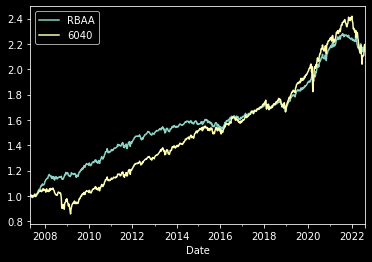

In [34]:
ptf=(ptfr+1).cumprod()
ptf.plot(label='RBAA')
static.plot(label='6040')
plt.legend()

In [35]:
portf=[pd.DataFrame(ptf),(returns_test[['S&P500']]+1).cumprod()*100,pd.DataFrame(static),]
st=[]
for i in portf:
    st.append(stats(i))
res=pd.DataFrame(st,index=['RBAA','SP500','6040'],columns=['CAGR','STD','Sharpe','avgDD','Sortino' ])

<AxesSubplot:>

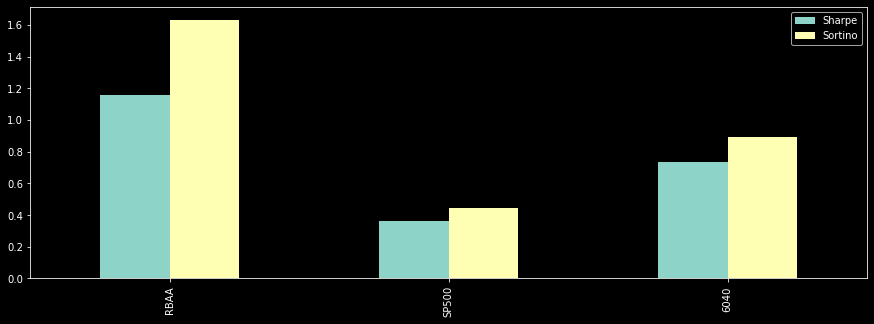

In [36]:
res[['Sharpe','Sortino']].plot.bar(figsize=(15,5))

<AxesSubplot:>

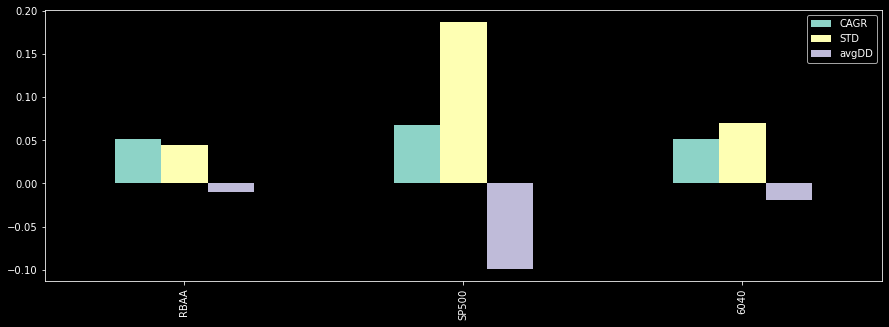

In [37]:
res[['CAGR','STD','avgDD']].plot.bar(figsize=(15,5))